In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
!pip install torchvision 
import torch
from transformers import AutoTokenizer, AutoModel
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from matplotlib.font_manager import FontProperties
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached torchvision-0.18.0-cp311-cp311-win_amd64.whl (1.2 MB)
  Using cached torch-2.3.0-cp311-cp311-win_amd64.whl (159.8 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python311\\Library'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'torch'

In [2]:
df= pd.read_csv("sentimentdataset.csv")

In [3]:
df.shape

(732, 15)

In [4]:
df.describe().loc[['min', '50%', 'mean', 'max', 'std']].T.style.background_gradient(axis=1)

,min,50%,mean,max,std
Unnamed: 0.1,0.000000,366.500000,366.464481,732.000000,211.513936
Unnamed: 0,0.000000,370.500000,369.740437,736.000000,212.428936
Retweets,5.000000,22.000000,21.508197,40.000000,7.061286
Likes,10.000000,43.000000,42.901639,80.000000,14.089848
Year,2010.000000,2021.000000,2020.471311,2023.000000,2.802285
Month,1.000000,6.000000,6.122951,12.000000,3.411763
Day,1.000000,15.000000,15.497268,31.000000,8.474553
Hour,0.000000,16.000000,15.521858,23.000000,4.113414


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [6]:
df.isna().sum()

Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64

In [7]:
df_columns= df.columns
for col in df.columns:
  print(col)

Unnamed: 0.1
Unnamed: 0
Text
Sentiment
Timestamp
User
Platform
Hashtags
Retweets
Likes
Country
Year
Month
Day
Hour


In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [9]:
df.duplicated().any()

False

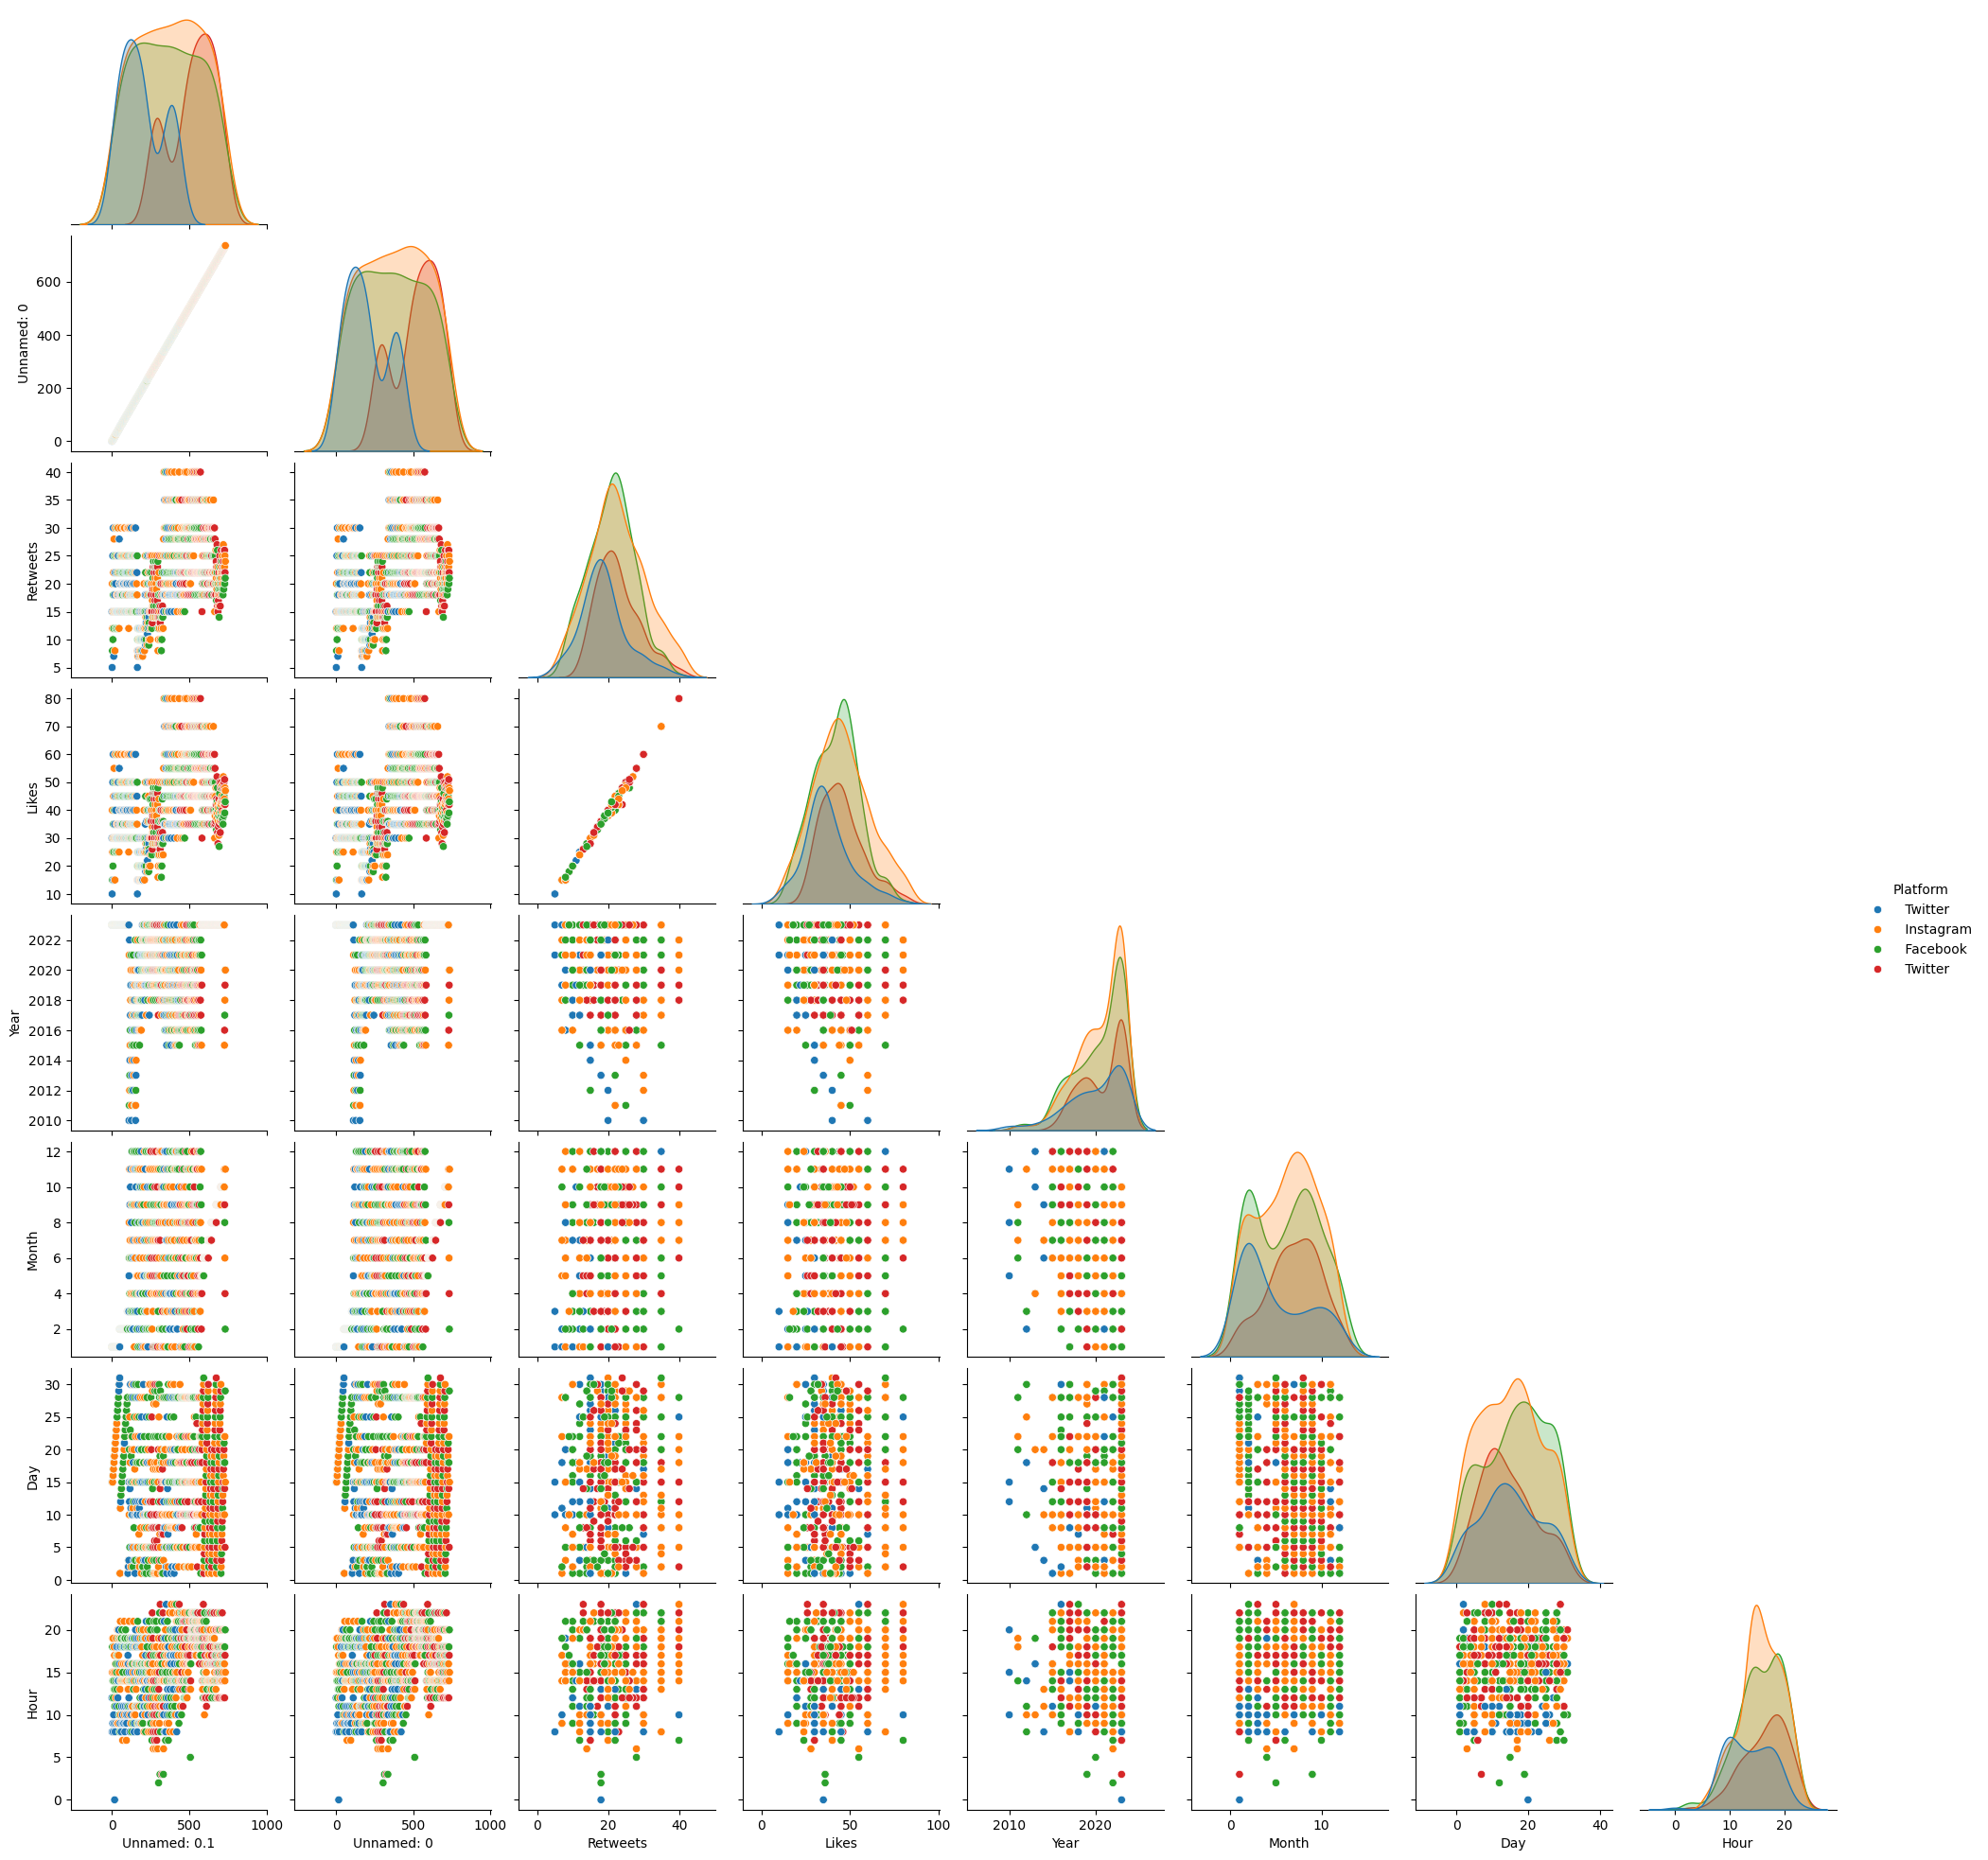

In [10]:
sns.pairplot(df, hue= 'Platform', corner= True)

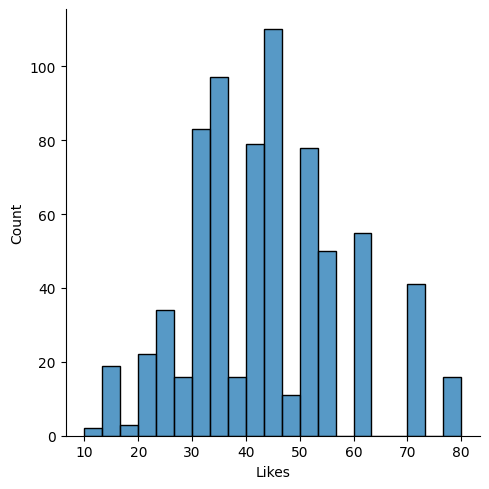

In [11]:
sns.displot(df.Likes)

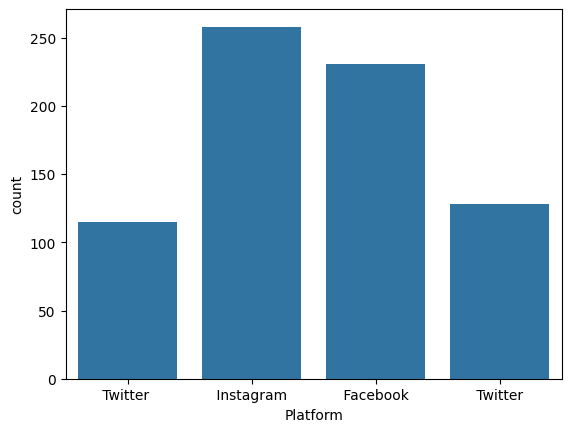

In [12]:
sns.countplot(x= 'Platform', data= df)
plt.show()

Text(0.5, 1.0, 'Platform Likes')

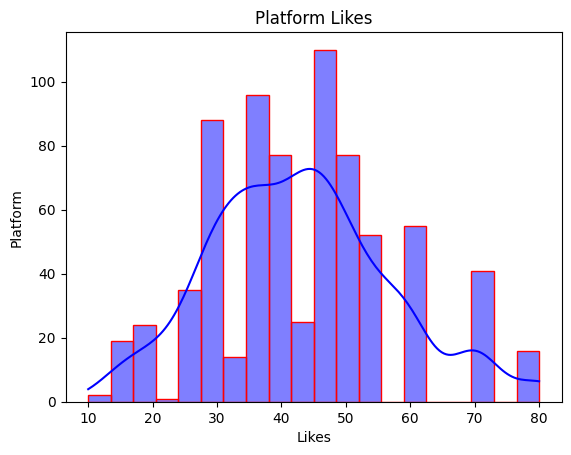

In [13]:
sns.histplot(df['Likes'], bins= 20, color= 'Blue', edgecolor= 'Red', kde= True)
plt.xlabel("Likes")
plt.ylabel("Platform")
plt.title("Platform Likes")

<Axes: xlabel='Hour', ylabel='Likes'>

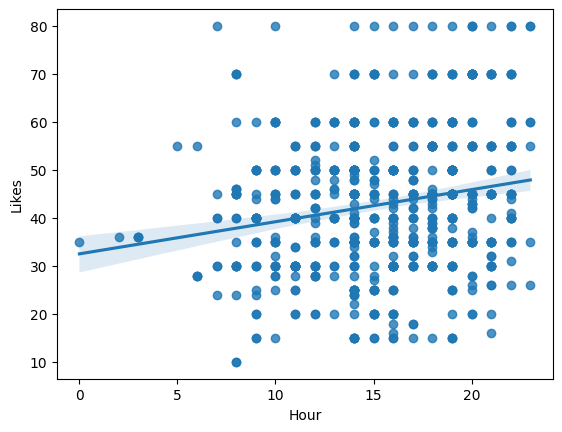

In [14]:
sns.regplot(data =df, x= 'Hour', y= 'Likes')

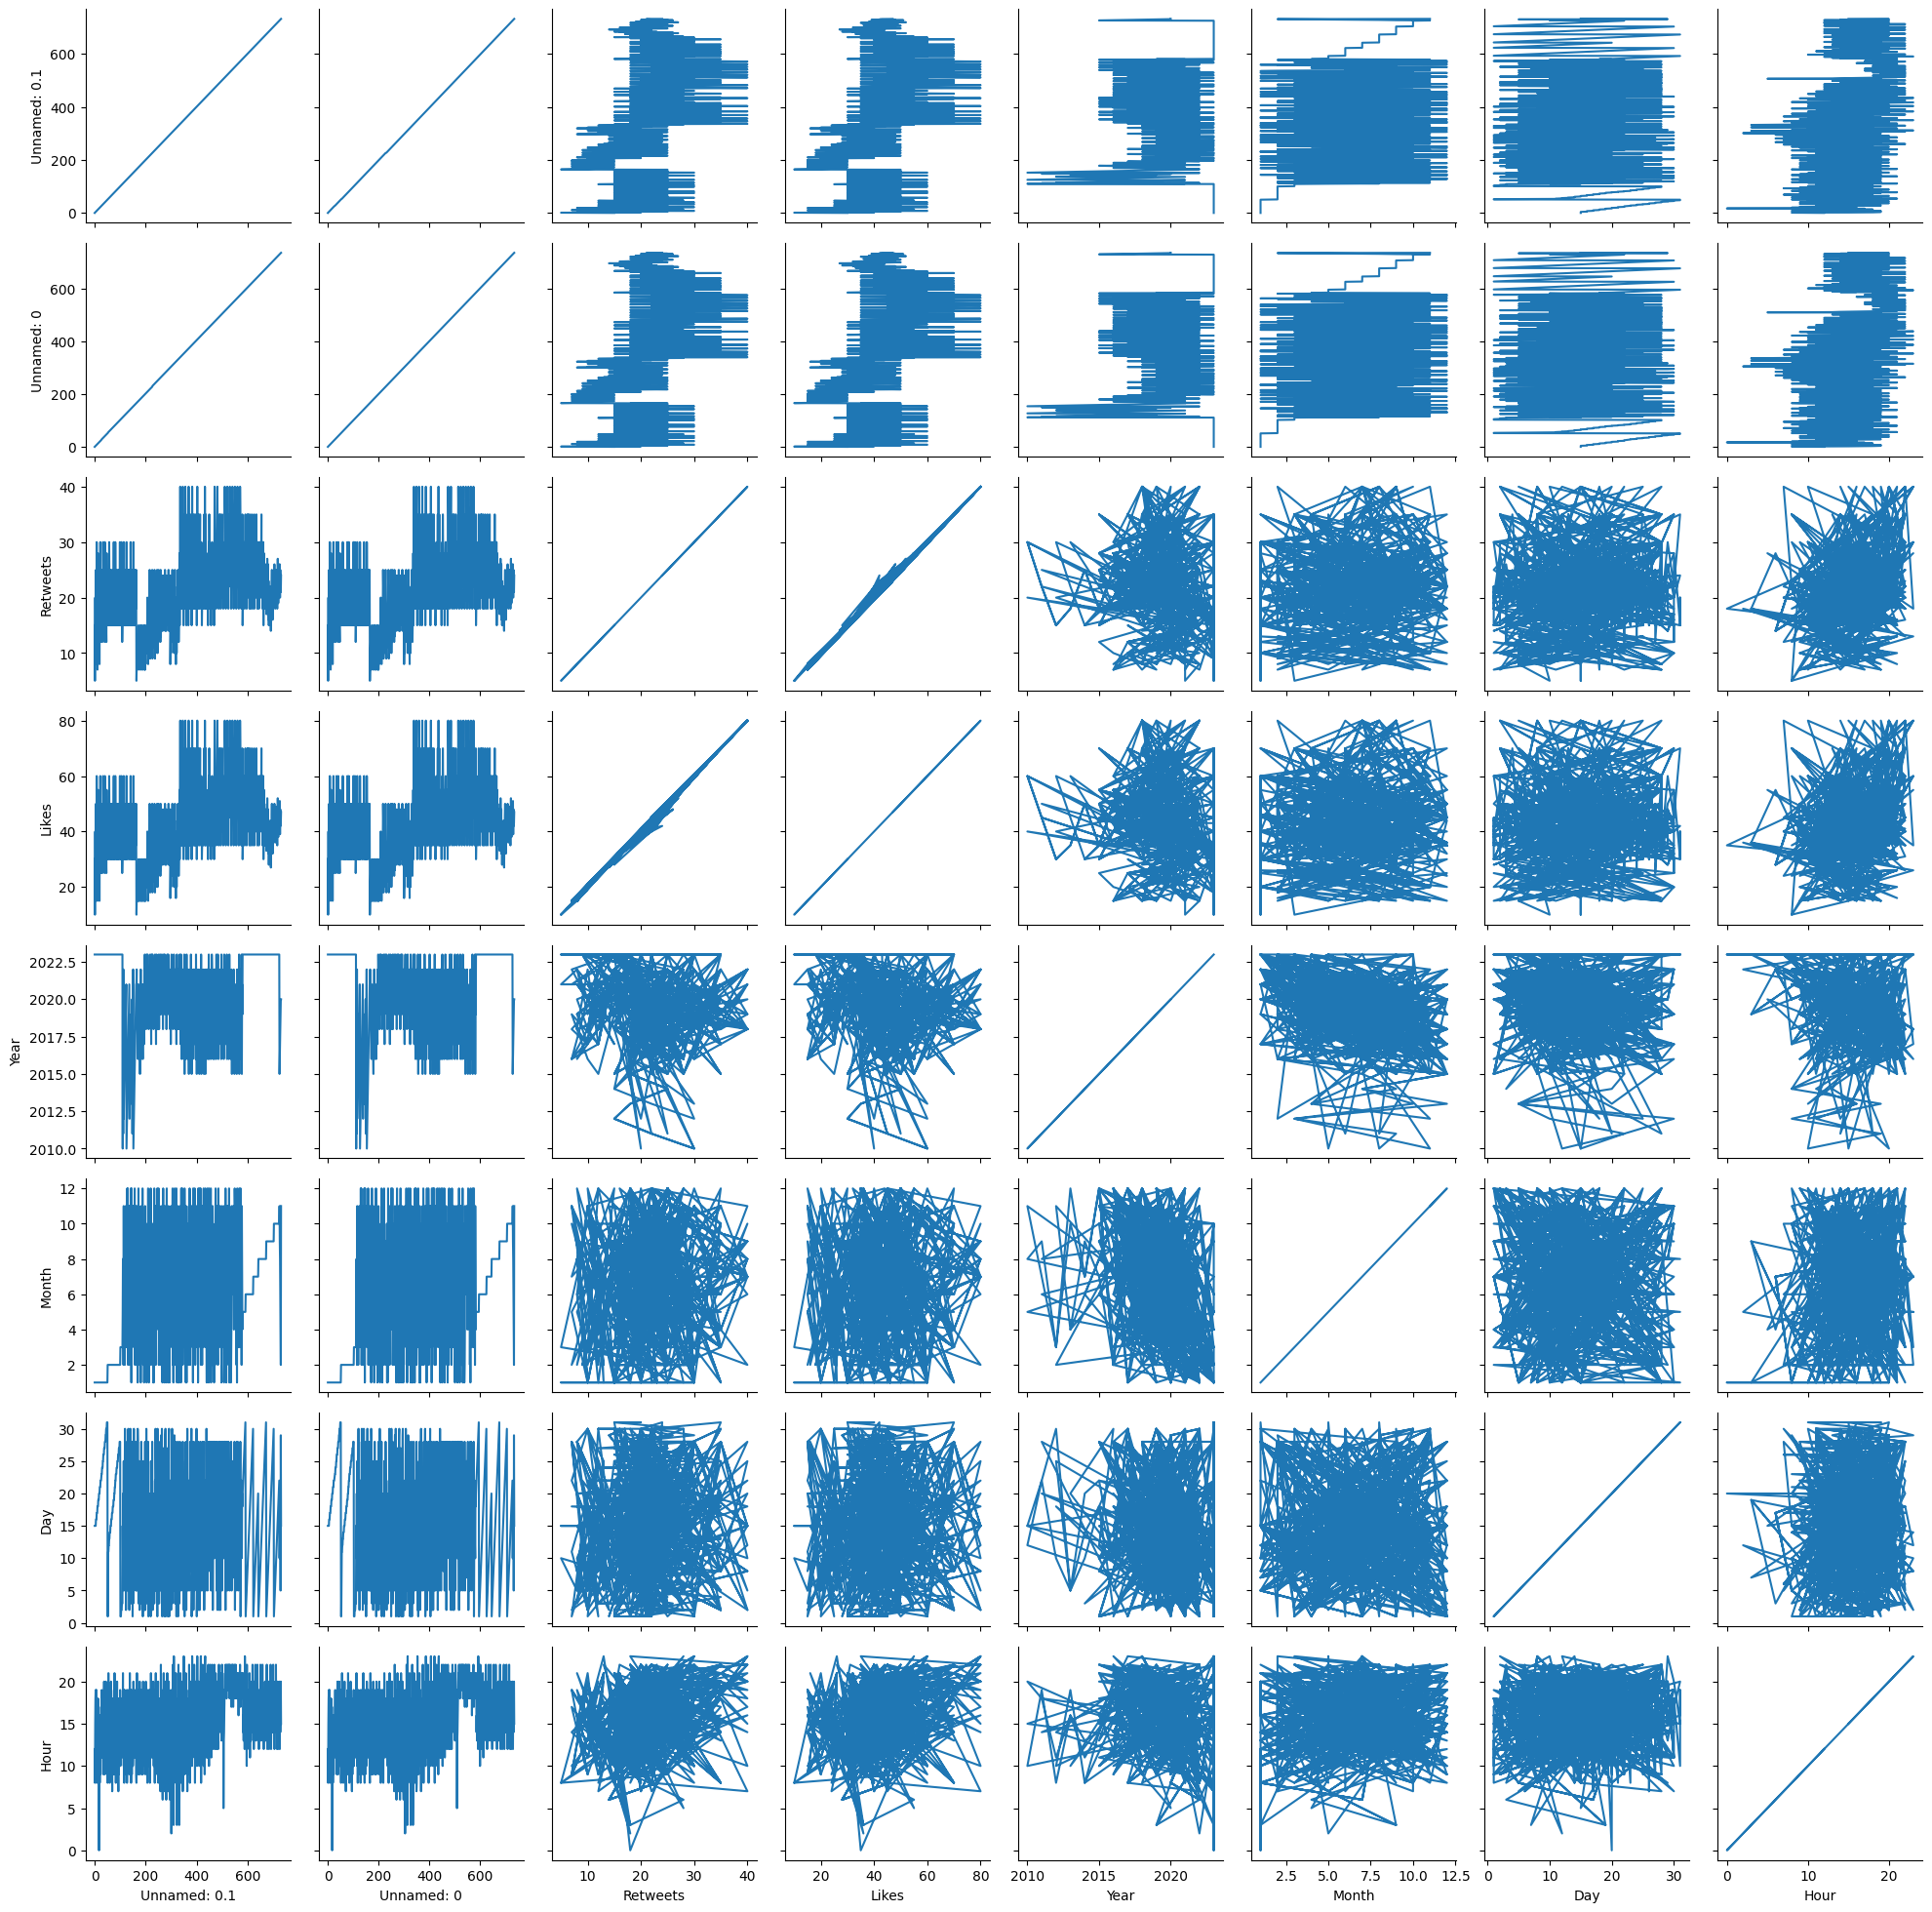

In [15]:
plot = sns.PairGrid(df)
plot.map(plt.plot)
plt.show()

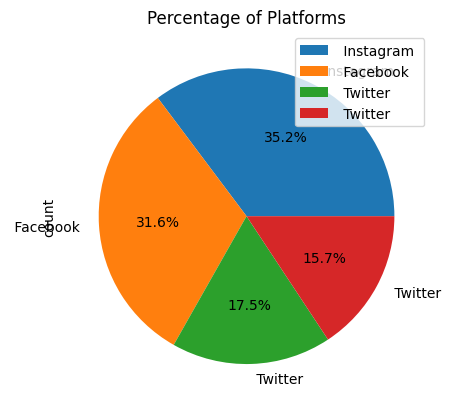

In [16]:
df['Platform'].value_counts().plot(kind= 'pie', autopct= '%1.1f%%')
plt.title('Percentage of Platforms')
plt.legend()
plt.show()

In [17]:
class_counts= df['Sentiment'].value_counts()
selected_classes= class_counts[class_counts>9].index
df.loc[~df['Sentiment'].isin(selected_classes), 'Sentiment'] = 'Miscellaneous'

In [18]:
df['Sentiment'].unique()

array([' Positive  ', 'Miscellaneous', ' Excitement ', ' Contentment ',
       ' Joy ', ' Neutral ', ' Happy '], dtype=object)

In [19]:
df['Sentiment'].value_counts()

Sentiment
Miscellaneous    572
 Positive         44
 Joy              42
 Excitement       32
 Contentment      14
 Neutral          14
 Happy            14
Name: count, dtype: int64

In [20]:
class_to_int={
    "Positive": 0,
    "Excitement": 1,
    "Contentment": 2,
    "Joy": 3,
    "Neutral": 4,
    "Happy": 5,
    "Miscellaneous": 6
}

df['Sentiment']= df['Sentiment'].replace(class_to_int)

df['Sentiment'].value_counts()

Sentiment
6                572
 Positive         44
 Joy              42
 Excitement       32
 Contentment      14
 Neutral          14
 Happy            14
Name: count, dtype: int64

In [21]:
class_names= ["Positive", "Excitment", "Contentment", "Joy", "Neutral", "Happy", "Miscellaneous"]
df1 = df[df['Sentiment']!= 6]
df1['Sentiment'].value_counts()

Sentiment
 Positive        44
 Joy             42
 Excitement      32
 Contentment     14
 Neutral         14
 Happy           14
Name: count, dtype: int64

In [22]:
def visualize_text_length(data, title):

    data['text_length'] = data['Text'].apply(len)

    plt.figure(figsize=(8, 4))

    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    plt.hist(data['text_length'], bins=40, color='lightcoral', edgecolor='black', alpha=0.7, label='Bangla News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')

    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')
    plt.show()

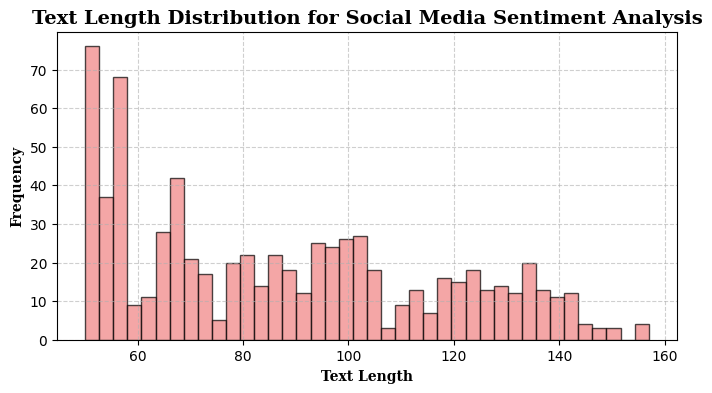

In [23]:
visualize_text_length(df, 'Social Media Sentiment Analysis')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [25]:
sample_txt = 'Enjoying a beautiful day at the park!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['En', '##joy', '##ing', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [13832, 18734, 1158, 170, 2712, 1285, 1120, 1103, 2493, 106]


In [26]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [31]:
token_lens = []

for txt in df.Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

<ipython-input-32-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


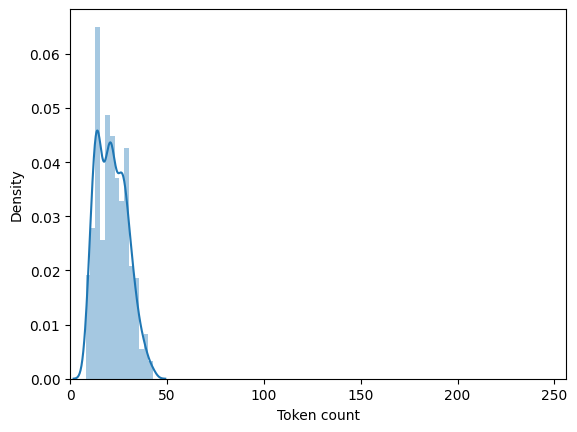

In [32]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [33]:
selected_columns = ['Text', 'Sentiment']
df = df[selected_columns]

MAX_LEN = 50

In [34]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [43]:
df_train.shape, df_val.shape, df_test.shape

((512, 2), (110, 2), (110, 2))

In [39]:
#don't run
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )


In [41]:
#don't run
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [46]:
data = next(iter(train_data_loader))
data.keys()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [47]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


In [48]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

In [49]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [51]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [52]:
model = SentimentClassifier(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length


torch.Size([8, 50])
torch.Size([8, 50])


In [53]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1046, 0.0675, 0.1731, 0.1281, 0.2533, 0.1351, 0.1383],
        [0.1533, 0.0739, 0.0897, 0.1296, 0.2855, 0.1546, 0.1133],
        [0.1206, 0.0395, 0.1206, 0.1464, 0.2032, 0.1428, 0.2269],
        [0.0932, 0.0706, 0.1231, 0.1050, 0.2456, 0.0876, 0.2748],
        [0.1475, 0.1067, 0.0861, 0.0787, 0.2451, 0.1077, 0.2281],
        [0.1180, 0.0751, 0.1643, 0.0808, 0.1894, 0.1687, 0.2037],
        [0.1375, 0.0792, 0.1301, 0.1087, 0.2187, 0.0993, 0.2264],
        [0.1254, 0.1107, 0.1499, 0.1010, 0.2250, 0.1425, 0.1456]],
       grad_fn=<SoftmaxBackward0>)

In [54]:
bert_model.config.hidden_size

768